# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
G1 = nx.read_gpickle("assets/A4_P1_G1")
G2 = nx.read_gpickle("assets/A4_P1_G2")
G3 = nx.read_gpickle("assets/A4_P1_G3")
G4 = nx.read_gpickle("assets/A4_P1_G4")
G5 = nx.read_gpickle("assets/A4_P1_G5")
P1_Graphs = [G1, G2, G3, G4, G5]

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs using any methodology and determine which of the three algorithms generated each graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

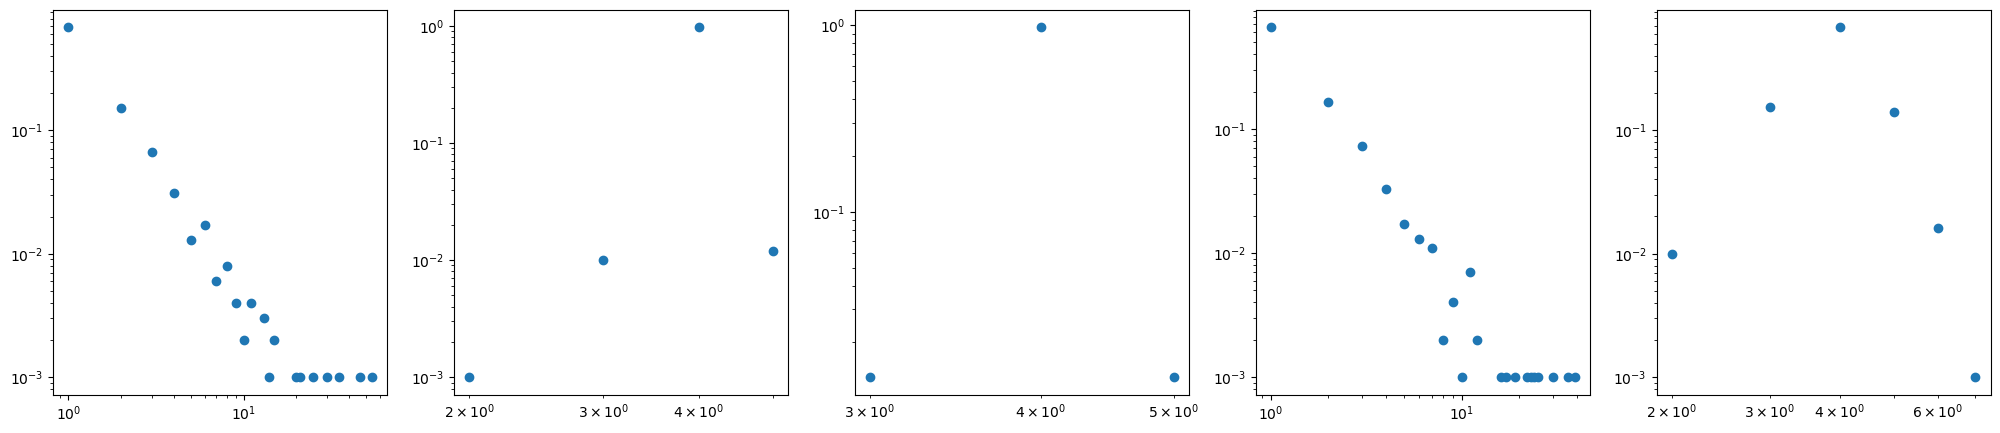

Graph 1: local clustering score:                  0.0 average shortest path length:    6.530506506506507
Graph 2: local clustering score:  0.49310000000000004 average shortest path length:    43.80284684684685
Graph 3: local clustering score:   0.4897333333333334 average shortest path length:   39.007695695695695
Graph 4: local clustering score:                  0.0 average shortest path length:    8.158990990990992
Graph 5: local clustering score:  0.36504285714285717 average shortest path length:    8.532046046046046


['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

In [73]:
def graph_identification():
    # use log probaility versus log degree plot
    import matplotlib.pyplot as plt
    figure = plt.figure(figsize=(25,5), dpi=100)
    for i, G in enumerate(P1_Graphs):
        plt.subplot(1, 5, i + 1)
        degrees = dict(G.degree()).values()
        n = len(degrees)
        prob = {}
        for d in degrees:
            prob[d] = prob.get(d, 0) + 1
        Xs = list(prob.keys())
        Ys = [x / n for x in prob.values()]
        plt.scatter(Xs, Ys, norm='log')
        plt.yscale('log')
        plt.xscale('log')
    plt.show()
    
    # use local clustering and average shortest path length
    for i, G in enumerate(P1_Graphs):
        print(f"Graph {i + 1}: local clustering score: {nx.average_clustering(G):20} average shortest path length: {nx.average_shortest_path_length(G):20}")
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

graph_identification()

In [10]:
ans_one = graph_identification()
assert type(ans_one) == list, "You must return a list"


---

## Part 2 - Company Emails

For the second part of this assignment you will be working with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagmentSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagmentSalary` indicates whether that person is receiving a managment position salary.

In [76]:
G = pickle.load(open('assets/email_prediction_NEW.txt', 'rb'))

print(f"Graph with {len(nx.nodes(G))} nodes and {len(nx.edges(G))} edges")

Graph with 1005 nodes and 16706 edges


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a managment position salary.

To accomplish this, you will need to create a matrix of node features of your choice using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a managment salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a managment position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a Pandas series of length 252 with the data being the probability of receiving managment salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [77]:
list(G.nodes(data=True))[:5] # print the first 5 nodes

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (581, {'Department': 3, 'ManagementSalary': 0.0}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (65, {'Department': 4, 'ManagementSalary': nan})]

In [105]:
def salary_predictions(verbose: bool = False):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score
    
    # feature engineering
    node_df = pd.DataFrame(index=G.nodes)
    node_df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department')).astype('category')
    node_df = pd.concat([node_df, pd.get_dummies(node_df['Department'])], axis=1)
    node_df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    node_df['degree'] = pd.Series(dict(G.degree()))
    node_df['clustering'] = pd.Series(nx.clustering(G))
    node_df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
    node_df['closeness_centrality'] = pd.Series(nx.closeness_centrality(G))
    node_df['betweenness_centrality'] = pd.Series(nx.betweenness_centrality(G))
    node_df['pagerank'] = pd.Series(nx.pagerank(G, alpha=0.85))
    hub, auth = nx.hits(G)
    node_df['hub'] = pd.Series(hub)
    node_df['auth'] = pd.Series(auth)
    
    # create train and test sets
    train = node_df.loc[~node_df['ManagementSalary'].isna()].copy()
    test = node_df.loc[node_df['ManagementSalary'].isna()].copy()
    train_y = train['ManagementSalary']
    train_x = train.drop('ManagementSalary', axis=1)
    test_x = test.drop('ManagementSalary', axis=1)
    test_index = test.index
    
    # modelling
    model = RandomForestClassifier(n_estimators=500, oob_score=True)
    model.fit(train_x, train_y)
    predictions = model.oob_decision_function_.argmax(axis=1)
    if verbose:
        print(f"ROC AUC Score: {roc_auc_score(train_y, predictions)}")
    
    # evaluate
    proba = pd.Series(model.predict_proba(test_x)[:, 1], index=test_index)
    return proba
    
salary_predictions(verbose=True)

ROC AUC Score: 0.767575484452456


1      0.050
65     0.918
18     0.060
215    0.700
283    0.992
       ...  
691    0.000
788    0.080
944    0.000
798    0.002
808    0.000
Length: 252, dtype: float64

In [79]:
ans_salary_preds = salary_predictions()
assert type(ans_salary_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_salary_preds) == 252, "The series must be of length 252"


### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [80]:
future_connections = pd.read_csv('assets/Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to:      
1. Create a matrix of features of your choice for the edges found in `future_connections` using Networkx     
2. Train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data     
3. Predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [113]:
def new_connections_predictions(verbose: bool = False):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score
    global future_connections
    edges_df = future_connections.copy()
    
    # edges_df['resource_allocation_index'] = pd.Series({(x[0], x[1]): x[2] for x in nx.resource_allocation_index(G)})
    edges_df['jaccard_coefficient'] = pd.Series({(x[0], x[1]): x[2] for x in nx.jaccard_coefficient(G)})
    edges_df['adamic_adar_index'] = pd.Series({(x[0], x[1]): x[2] for x in nx.adamic_adar_index(G)})
    edges_df['preferential_attachment'] = pd.Series({(x[0], x[1]): x[2] for x in nx.preferential_attachment(G)})
    edges_df['cn_soundarajan_hopcroft'] = pd.Series({(x[0], x[1]): x[2] for x in nx.cn_soundarajan_hopcroft(G, community='Department')})
    edges_df['ra_index_soundarajan_hopcroft'] = pd.Series({(x[0], x[1]): x[2] for x in nx.ra_index_soundarajan_hopcroft(G, community='Department')})
    # edges_df['common_neighbor_centrality'] = pd.Series({(x[0], x[1]): x[2] for x in nx.common_neighbor_centrality(G)})
    
    train = edges_df.loc[~edges_df['Future Connection'].isna()]
    test = edges_df.loc[edges_df['Future Connection'].isna()]
    
    train_y = train['Future Connection']
    train_x = train.drop('Future Connection', axis=1)

    test_x = test.drop('Future Connection', axis=1)
    test_index = test.index
    
    model = RandomForestClassifier(n_estimators=100, oob_score=True)
    model.fit(train_x, train_y)
    predictions = model.oob_decision_function_.argmax(axis=1)
    if verbose:
        print(f"ROC AUC Score: {roc_auc_score(train_y, predictions)}")

    proba = pd.Series(model.predict_proba(test_x)[:, 1], index=test_index)
    return proba

new_connections_predictions(verbose=True)

ROC AUC Score: 0.8089163456780573


(107, 348)    0.000000
(542, 751)    0.011153
(20, 426)     0.470000
(50, 989)     0.018515
(942, 986)    0.008949
                ...   
(165, 923)    0.013689
(673, 755)    0.007820
(939, 940)    0.008949
(555, 905)    0.020159
(75, 101)     0.000000
Length: 122112, dtype: float64

In [ ]:
ans_prob_preds = new_connections_predictions()
assert type(ans_prob_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_prob_preds) == 122112, "The series must be of length 122112"
